In [3]:
import pandas as pd
import numpy as np

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
sns.set(font_scale=2.5)

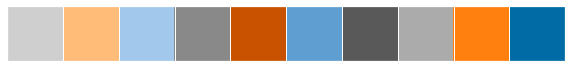

In [6]:
# using a color-blind friendly palette with 10 colors
color_blind_palette_10 = ['#cfcfcf', '#ffbc79', '#a2c8ec', '#898989', '#c85200',
                          '#5f9ed1', '#595959', '#ababab', '#ff800e', '#006ba4']

sns.palplot(color_blind_palette_10)

# Загрузка данных

## Фильмы

In [7]:
top_n_movie_ratings = pd.read_csv('data/top-n-movies_user-ratings.csv').drop(columns='Unnamed: 0')

In [8]:
top_n_movie_ratings.head()

,user_id,movie_id,rating,movie_title
0,307,0,4,Toy Story
1,250,99,4,Fargo
2,24,180,5,Return of the Jedi
3,19,287,1,Scream
4,31,293,3,Liar Liar


In [9]:
# create a dictionary between movie_id and movie_title (since the results output doesn't have titles)
movie_titles = top_n_movie_ratings.groupby(['movie_id','movie_title']).size().to_frame() \
                                    .reset_index('movie_title').movie_title \
                                    .to_dict()
movie_titles

{0: 'Toy Story',
 49: 'Star Wars',
 99: 'Fargo',
 120: 'Independence Day',
 180: 'Return of the Jedi',
 257: 'Contact',
 285: 'English Patient, The',
 287: 'Scream',
 293: 'Liar Liar',
 299: 'Air Force One'}

### Create a dictionary to map these movies to colors for plots

In [10]:
color_map = dict(zip(top_n_movie_ratings.movie_title.sort_values().unique().tolist(), color_blind_palette_10))
color_map

{'Air Force One': '#cfcfcf',
 'Contact': '#ffbc79',
 'English Patient, The': '#a2c8ec',
 'Fargo': '#898989',
 'Independence Day': '#c85200',
 'Liar Liar': '#5f9ed1',
 'Return of the Jedi': '#595959',
 'Scream': '#ababab',
 'Star Wars': '#ff800e',
 'Toy Story': '#006ba4'}

# Результаты

## A/B Test Output

In [11]:
ab_test_1k = pd.read_csv('output/ab_test_1k.csv').drop(columns='Unnamed: 0')

In [12]:
ab_test_1k.head()

,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,120,12,1,1,1.000000
1,0,1,299,783,0,1,0.500000
2,0,2,49,649,1,2,0.666667
3,0,3,49,837,1,3,0.750000
4,0,4,49,483,1,4,0.800000


In [13]:
ab_test_5k = pd.read_csv('output/ab_test_5k.csv').drop(columns='Unnamed: 0')

In [14]:
ab_test_5k.head()

,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,120,12,1,1,1.000000
1,0,1,299,783,0,1,0.500000
2,0,2,49,649,1,2,0.666667
3,0,3,49,837,1,3,0.750000
4,0,4,49,483,1,4,0.800000


## $\epsilon$-Greedy Output

In [15]:
eps_greedy_05 = pd.read_csv('output/epsilon_greedy_05.csv').drop(columns='Unnamed: 0')

In [16]:
eps_greedy_05.head()

,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,0,12,0,0,0.0
1,0,1,257,58,0,0,0.0
2,0,2,0,222,0,0,0.0
3,0,3,0,830,0,0,0.0
4,0,4,0,313,1,1,0.2


In [17]:
eps_greedy_10 = pd.read_csv('output/epsilon_greedy_10.csv').drop(columns='Unnamed: 0')

In [18]:
eps_greedy_10.head()

,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,0,12,0,0,0.0
1,0,1,257,58,0,0,0.0
2,0,2,0,222,0,0,0.0
3,0,3,0,830,0,0,0.0
4,0,4,0,313,1,1,0.2


## Thompson Sampling Output

In [19]:
thompson = pd.read_csv('output/thompson_sampling.csv').drop(columns='Unnamed: 0')

In [20]:
thompson.head()

,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,299,12,0,0,0.000000
1,0,1,49,333,1,1,0.500000
2,0,2,49,693,1,2,0.666667
3,0,3,49,479,0,2,0.500000
4,0,4,120,525,0,2,0.400000


### Визуализируем результаты стратегии Thomson Sampling

In [21]:
# create a dataframe with running totals of how many times each recommendation was taken
thompson_running_ttl = thompson.query('iteration == 0') \
                                .eval('selected = 1') \
                                .pivot(index='visit', columns='item_id', values='selected') \
                                .fillna(0) \
                                .cumsum(axis=0) \
                                .reset_index() \
                                .rename(columns=movie_titles)

In [22]:
# scale the value by the visit number to get turn the running total into a percentage
thompson_running_ttl.iloc[:,1:] = thompson_running_ttl.iloc[:,1:].div((thompson_running_ttl.visit + 1)/100, axis=0)

In [23]:
thompson_running_ttl.head()

item_id,visit,Toy Story,Star Wars,Fargo,Independence Day,Return of the Jedi,Contact,"English Patient, The",Scream,Liar Liar,Air Force One
0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000
1,1,0.0,50.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.000000
2,2,0.0,66.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.333333
3,3,0.0,75.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.000000
4,4,0.0,60.000000,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.000000


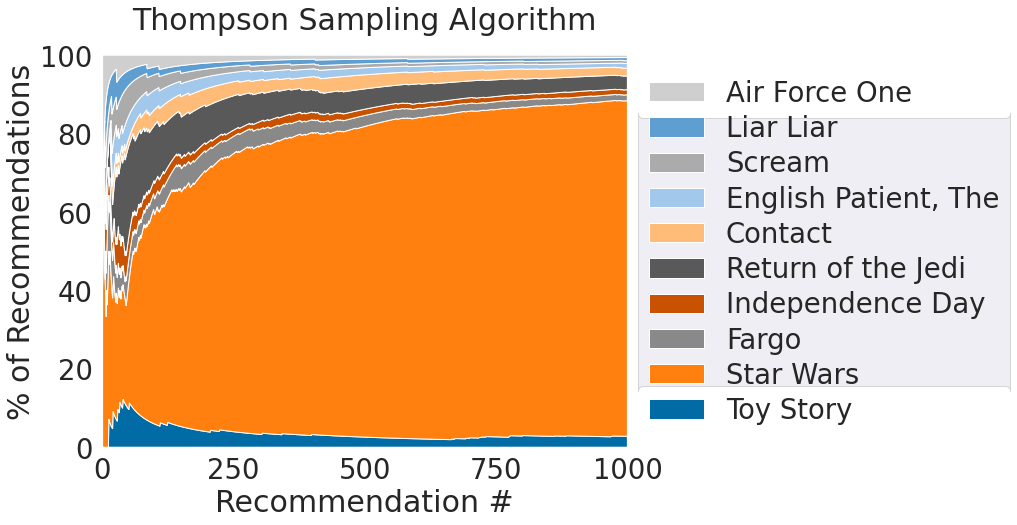

In [24]:
sns.set_palette(color_blind_palette_10)

fig, ax = plt.subplots(figsize=(10,8))

ax.stackplot(thompson_running_ttl.visit,
             thompson_running_ttl.iloc[:,1:11].T,
             labels=thompson_running_ttl.iloc[:,1:11].columns.values.tolist(),
             colors=[color_map[x] for x in thompson_running_ttl.iloc[:,1:].columns.values]
            )

ax.set_xlim(0,1000)
ax.set_xticks(range(0, 1100, 250))

ax.set_title('Thompson Sampling Algorithm')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recommendations')

lgd = plt.legend(bbox_to_anchor=(1.02, 0.15), loc=2, borderaxespad=0., labelspacing=-2.3)

ax.set_facecolor('w')

plt.tight_layout()
plt.show()

In [25]:
fig.savefig('output/images/bandit_results.png', transparent=False, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Group the data to average over the runs

## A/B Test

In [26]:
ab_test_1k_avg = ab_test_1k.groupby('visit', as_index=False).mean()

In [27]:
ab_test_1k_avg.head()

,visit,iteration,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,9.5,156.1,431.85,0.40,0.40,0.400000
1,1,9.5,172.4,470.55,0.25,0.65,0.325000
2,2,9.5,154.9,512.85,0.35,1.00,0.333333
3,3,9.5,181.4,424.95,0.35,1.35,0.337500
4,4,9.5,200.4,559.00,0.25,1.60,0.320000


In [28]:
ab_test_5k_avg = ab_test_5k.groupby(['visit'], as_index=False).mean()

In [29]:
ab_test_5k_avg.head()

,visit,iteration,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,9.5,181.55,534.90,0.15,0.15,0.150
1,1,9.5,190.00,445.60,0.30,0.45,0.225
2,2,9.5,127.45,527.70,0.30,0.75,0.250
3,3,9.5,131.30,459.80,0.55,1.30,0.325
4,4,9.5,167.40,489.85,0.35,1.65,0.330


## $\epsilon$-Greedy

In [30]:
eps_greedy_05_avg = eps_greedy_05.groupby(['visit'], as_index=False).mean()

In [31]:
eps_greedy_05_avg.head()

,visit,iteration,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,9.5,20.95,555.05,0.20,0.20,0.200000
1,1,9.5,12.85,576.85,0.00,0.20,0.100000
2,2,9.5,0.00,417.70,0.35,0.55,0.183333
3,3,9.5,16.80,466.30,0.25,0.80,0.200000
4,4,9.5,0.00,506.50,0.30,1.10,0.220000


In [32]:
eps_greedy_10_avg = eps_greedy_10.groupby(['visit'], as_index=False).mean()

In [33]:
eps_greedy_10_avg.head()

,visit,iteration,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,9.5,37.70,464.60,0.20,0.20,0.200000
1,1,9.5,47.15,363.45,0.15,0.35,0.175000
2,2,9.5,63.05,362.55,0.30,0.65,0.216667
3,3,9.5,48.10,558.55,0.15,0.80,0.200000
4,4,9.5,33.55,363.95,0.35,1.15,0.230000


## Thompson Sampling

In [34]:
thompson_avg = thompson.groupby(['visit'], as_index=False).mean()

In [35]:
thompson_avg.head()

,visit,iteration,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,9.5,212.85,402.80,0.25,0.25,0.250000
1,1,9.5,198.55,410.75,0.60,0.85,0.425000
2,2,9.5,199.05,489.05,0.40,1.25,0.416667
3,3,9.5,147.90,335.60,0.30,1.55,0.387500
4,4,9.5,141.15,443.55,0.15,1.70,0.340000


## Подведем итоги

#### Рисуем процент рекомендаций, которые понравились пользователю.

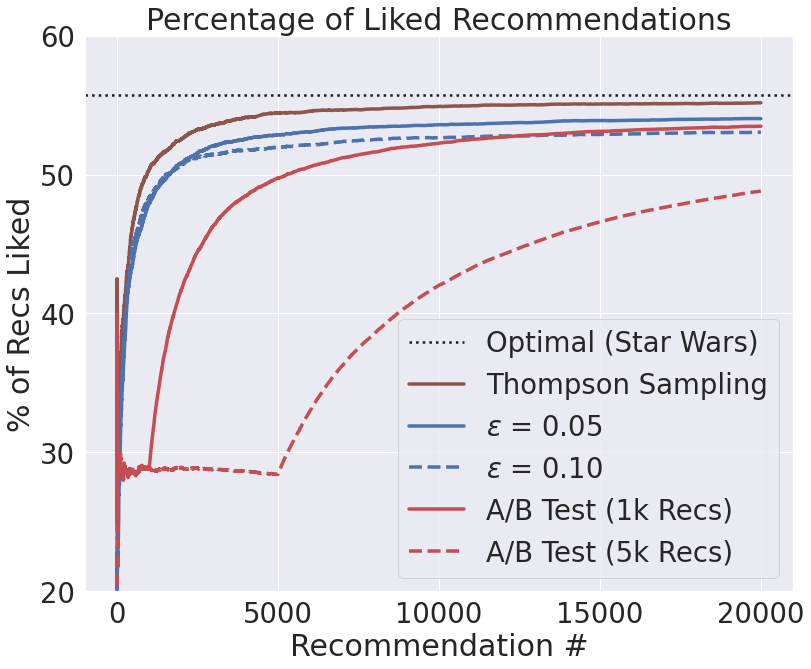

In [36]:
fig, ax = plt.subplots(figsize=(12,10))

# add a line for the optimal value -- 0.5575 for Star Wars (from exploration noteboook)
ax.axhline(y=0.5575, color='k', linestyle=':', linewidth=2.5)

for (avg_results_df, style) in [(thompson_avg, 'tab:brown'),
                                (eps_greedy_05_avg, 'b-'),
                                (eps_greedy_10_avg, 'b--'),
                                (ab_test_1k_avg, 'r-'),
                                (ab_test_5k_avg, 'r--')]:
    
    ax.plot(avg_results_df.visit, avg_results_df.fraction_relevant, style, linewidth=3.5)

ax.set_title('Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

ax.set_xticks(range(0,22000,5000))
ax.set_ylim(0.2, 0.6)
ax.set_yticks(np.arange(0.2, 0.7, 0.1))

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['Optimal (Star Wars)',
           'Thompson Sampling',
           '$\epsilon$ = 0.05',
           '$\epsilon$ = 0.10',
           'A/B Test (1k Recs)',
           'A/B Test (5k Recs)'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()

In [37]:
fig.savefig('output/images/pct_liked_recs.png', transparent=False)